# Stop... Query Time! 

let's take a few gigs of data and run it through some query methods.  

In [1]:
import duckdb
import polars as pl

In [2]:
parquet_path = 'output/df1/*.parquet'

## DuckDB

If you can't duck it... 

First we'll use DuckDB and look at the size of our data set

In [3]:
con = duckdb.connect()

In [4]:
%%time

df = con.execute(f"SELECT count(1) as rec_count FROM '{parquet_path}' ").df()
df

CPU times: user 2.22 s, sys: 1.14 s, total: 3.36 s
Wall time: 4.68 s


,rec_count
0,3992769124


Cool, so we have ~4 billion rows. It's around 50 GB on disk. Let's do a group by and count

In [5]:
%%time

df = con.execute(f"""
                 SELECT group1, 
                     count(1) as rec_count
                 FROM '{parquet_path}' 
                 GROUP BY
                     group1
                 """).df()
df

CPU times: user 2min 29s, sys: 6.87 s, total: 2min 36s
Wall time: 16.3 s


,group1,rec_count
0,9,443675479
1,8,443652115
2,6,443603318
3,7,443638855
4,4,443621397
5,5,443649122
6,3,443620954
7,2,443667068
8,1,443640816


My MBP has 32GB RAM and 8 processors. You can see the effect of the multiprocessors above by contrasting the CPU time (2:36) to the Wall time of 0:16

let's see how much slower summing is than just counting:

In [6]:
%%time

df = con.execute(f"""
                 SELECT group1, 
                     sum(value) as sum_value
                 FROM '{parquet_path}' 
                 GROUP BY
                     group1
                 """).df()
df

CPU times: user 3min 27s, sys: 39.2 s, total: 4min 6s
Wall time: 26.8 s


,group1,sum_value
0,3,2.218020e+08
1,4,2.218112e+08
2,1,2.218182e+08
3,2,2.218359e+08
4,6,2.217947e+08
5,5,2.218246e+08
6,7,2.218255e+08
7,8,2.218272e+08
8,9,2.218287e+08


Summing takes a bit longer than just counting. That's not too shocking I guess. 

## Polars 

Polars is an interesting project that uses syntax more like Pandas. Let's do our aggregations in Polars:

In [7]:
%%time
q = pl.scan_parquet(parquet_path).groupby("group1").agg(pl.col("value").count())

df = q.collect()
df

CPU times: user 3min 30s, sys: 8min 50s, total: 12min 21s
Wall time: 10min 32s


group1,value
i64,u32
1,443640816
8,443652115
4,443621397
5,443649122
2,443667068
3,443620954
7,443638855
9,443675479
6,443603318


In [8]:
%%time

q = pl.scan_parquet(parquet_path).groupby("group1").agg(pl.col("value").sum())

df = q.collect()
df

CPU times: user 4min 29s, sys: 15min 1s, total: 19min 30s
Wall time: 14min 18s


group1,value
i64,f64
4,2.2181e8
9,2.2183e8
8,2.2183e8
7,2.2183e8
1,2.2182e8
5,2.2182e8
6,2.2179e8
2,2.2184e8
3,2.2180e8


I was a little surprised this was slower than DuckDB by this margin. However after some discussion on Twitter, Ritchie Vink stopped by and told me that the purpose of Polars was not to do "larger than RAM" operations but to have fast parallel processing on in RAM structures. I had not realized that and I guess I'm lucky the above operations worked at all!

Convo with Ritchie:

https://twitter.com/RitchieVink/status/1571917508042698752?s=20&t=tF-oWL7CZU4kL6RWgik9pg

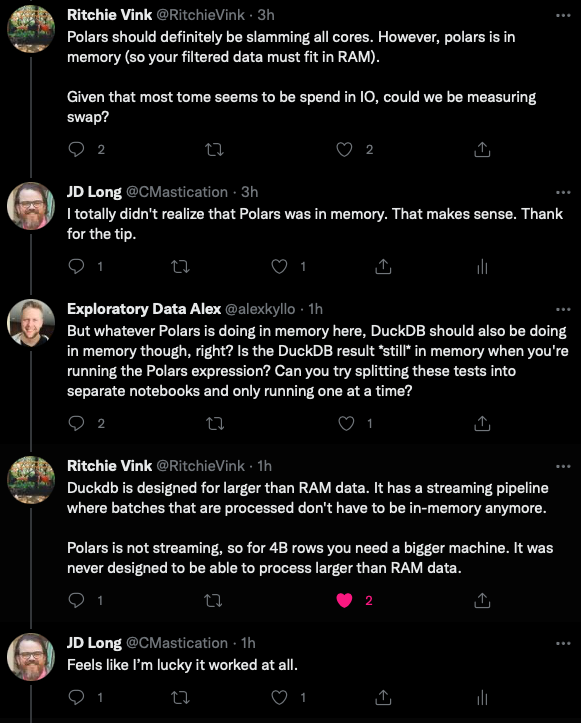